In [ ]:
 >>> nltk.download('stopwords')

In [3]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist

import nltk
import string
# nltk.download('stopwords')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src import nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

from joblib import parallel_backend

import dask.array as da

# Wall Street Forum Topic Modeling

## Data Import and Tf-Idf Vectorization

In [4]:
wallstreet = pd.read_csv('data/wallstreet_master.csv', engine='python')
wallstreet['lemmatized_tokens'] = wallstreet['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))
docs_raw = [' '.join(d) for d in wallstreet['lemmatized_tokens']]

In [5]:
n_topics = 20
max_doc_freq = 0.7
min_doc_freq = 4
max_features = 10000
ngram_rng = [1, 1]
max_iterations = 25
random_state=3
min_len = 1

In [6]:
docs_vectorized, vectorizer = nlp_topic_utils.tfidf_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_features, ngram_rng)

## TruncatedSVD

In [10]:
docs_dask_arr = da.from_array(docs_vectorized, chunks='auto', asarray=True)

In [9]:
def select_tsvd_num_components(var_ratio, var_explained_threshold):
    '''
    Determines the number of components required for TruncatedSVD to achieve the threshold of variance explained.
    '''
    total_var = 0
    n_components = 0
    
    for explained_var in var_ratio:
        total_var += explained_var
        n_components += 1
        
        if total_var >= var_explained_threshold:
            break
    
    return n_components

In [13]:
docs_dask_arr.shape

(45372, 10000)

In [16]:
#with parallel_backend('threading', n_jobs=-1):
tsvd = TruncatedSVD(n_components=docs_dask_arr.shape[1])
docs_tsvd = tsvd.fit(docs_dask_arr)

IndexError: tuple index out of range

In [ ]:
# Identify the required number of components to achieve the desired threshold of variance explained.
var_explained_threshold = 0.90

tsvd_var_ratios = tsvd.explained_variance_ratio_
tsvd_num_components = select_tsvd_num_components(tsvd_var_ratios, var_explained_threshold)

In [9]:
# with parallel_backend('threading', n_jobs=-1):
tsvd = TruncatedSVD(n_components=tsvd_num_components, random_state=random_state)
docs_tsvd = tsvd.fit_transform(docs_vectorized)

NameError: name 'tsvd_num_components' is not defined

---
## K-Means

In [56]:
vocab = list(vectorizer.vocabulary_.keys())
np.unique(vocab, return_counts=True)[:10]

(array(['___', '___ ___', '___ tasting', ..., 'zu', 'zum', 'über'],
       dtype='<U34'),
 array([1, 1, 1, ..., 1, 1, 1]))

In [20]:
docs_vectorized.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'Sum of Squared Errors')

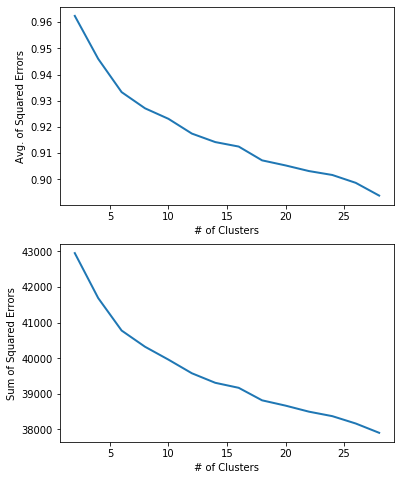

In [69]:
# Identify number of cluseters using the "Elbow" method

# distortion is the average of the squared distances from the cluster centers of the respective clusters.
distortions = []
distortion_map = {}

# Inertia is the sum of squared distances of samples to their closest cluster center
inertias = []
inertia_map = {}

k_rng = np.arange(2, 30, 2)

for k in k_rng:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(docs_vectorized)
    pred = kmeans.predict(docs_vectorized)
    centroids = kmeans.cluster_centers_
    
    d = sum(np.min(cdist(docs_vectorized.toarray(), centroids, metric='euclidean'), axis=1)) / docs_vectorized.shape[0]
    distortions.append(d)
    distortion_map[k] = d
    
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

ax[0].plot(k_rng, distortions, linewidth=2)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Avg. of Squared Errors')

ax[1].plot(k_rng, inertias, linewidth=2)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Sum of Squared Errors')
plt.tight_layout(); 


In [70]:
# Instiate KMeans model object.
# Input k
best_k = 18
kmeans = KMeans(n_clusters=best_k, random_state=random_state, n_jobs=-1)
kmeans.fit(docs_vectorized)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=18, n_jobs=-1, random_state=3)

In [27]:
print(k_clusters_centers.shape)

(18, 10000)


In [71]:
clusters = kmeans.labels_
k_clusters_centers = kmeans.cluster_centers_
# original_space_centroids = tsvd.inverse_transform(k_clusters_centers)
# argsort() returns the indices of the sorted values.
ordered_centroids = k_clusters_centers.argsort()[:, ::-1]

In [72]:
n_top_words = 10
words = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(k_clusters_centers):
        top_words_arr = [words[i] for i in ordered_centroids[topic_idx, : n_top_words]]
        print("\nCluster #{}:".format(topic_idx))
        print(" ".join(top_words_arr))


Cluster #0:
market thanks interested pm offer wrote check need looking wsm

Cluster #1:
onionshop mirror use unfree rebellion existence act absolutely become deal

Cluster #2:
bank drop account paypal transfer need method cashout money wrote

Cluster #3:
room chat everythingcc log change day fraud cashout bank one

Cluster #4:
picsou shop link wsm bump fresh bro login update wrote

Cluster #5:
pgp signature begin message end signed hash version gnupg key

Cluster #6:
guide cashout bank record ssn pack extra offer link retirement

Cluster #7:
welcome phished rule wsm help boat broder badge bro luck

Cluster #8:
contact external allowed rule read link forum help jabber phished

Cluster #9:
card credit cc debit fullz gift carding wrote need use

Cluster #10:
profile weed italian kallashnikov carfentanyl ephedrine heroin ecstasy hcl amphetamine

Cluster #11:
vendor wrote know good need like market one make money

Cluster #12:
order quality product vendor sample day utopia time best wsm

C